In [1]:
import torch, random, copy, scipy, math
from scipy.stats import ks_2samp, wasserstein_distance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
files = ['signal','wpwmdl','ttlep','zjj','twj']

In [3]:
gx = 0.3
gx_orig = 0.1

cs_mg  = {'signal'  : 1.682e-06 * (gx**2)/(gx_orig**2),
          'sig_sec' : 8.32e-5,
          'ttlep'   : 8.844e-3,
          'wpwmdl'  : 5.43e-4,
          'zjj'     : 1.066e-3,
          'twj'     : 8.584e-4}

cs_nmg = {'signal'  : 1,
          'sig_sec' : 1,
          'ttlep'   : 14.464,
          'wpwmdl'  : 1.484,
          'zjj'     : 942.7,
          'twj'     : 1.166}

cs_theory = {'signal'  : 1,
             'sig_sec' : 1,
             'ttlep'   : 988.57,
             'wpwmdl'  : 124.31,
             'zjj'     : 6.33e4,
             'twj'     : 83.10}

# For w, muon is a 0.1 branching ratio
# Fow z, muon is a 0.03 branching ratio
branch_ratio = {'signal' : 1,
                'sig_sec' : 1,
                'ttlep'  : 0.1*0.1,
                'wpwmdl' : 0.1*0.1*2,
                'zjj'    : 0.03362,
                'twj'    : 0.1*0.1} 

In [4]:
cs_fb = {}
for f in files:
    cs_fb[f] = ((cs_theory[f]*branch_ratio[f])/cs_nmg[f])*cs_mg[f]*1e3

In [5]:
## Import data
paths = ["n2n2", "ttlep", "twj", "wpwmdl", "zjj"]
data_imp = {}
for i in paths:
    data_imp[i] = pd.read_csv("./csv/" + i + ".csv").dropna(how="any").head(10000)
# normalize data
def scale_data(x, new_min, new_max):
    x = x.values
    x_min, x_max = min(x), max(x)
    x_range = x_max - x_min
    scaled_x = ((x - x_min)/x_range)*(new_max - new_min) + new_min
    return scaled_x

for proc in data_imp:
    for col in list(data_imp[proc].columns):
        data_imp[proc][col] = scale_data(data_imp[proc][col], new_max=1, new_min=-1)

In [6]:
data_imp["n2n2"].head()

,ptl,etal,energyl,ptj1,ptj2,ptj3,etaj,energyj,massj,mjj,...,rjl,rll,met,ht,mmll,n21_1,n21_2,n32_1,n32_2,infl
0,-0.013141,0.326453,-0.393568,-0.553404,-0.960409,-0.986823,-0.029821,-0.762966,-0.537757,-0.771258,...,-0.669613,0.280185,-0.783476,-0.085276,0.217409,-0.724449,-0.711586,0.306881,-0.258672,0.111063
1,-0.814953,0.781582,-0.600197,-0.023920,-0.419903,-0.838462,-0.035560,-0.445111,-0.513545,-0.260718,...,0.272615,0.703745,-0.786662,-0.368598,-0.106923,-0.661059,-0.638617,0.117474,0.088916,0.176584
2,-0.228371,0.052575,-0.642703,-0.494656,-0.476438,-0.975148,-0.210699,-0.693961,-0.828113,-0.614221,...,-0.211575,-0.106360,-0.685317,-0.191004,-0.249100,0.518366,0.189315,-0.163806,0.439525,0.078718
3,-0.732574,0.433633,-0.779079,-0.079486,-0.377326,-0.561523,-0.027400,-0.477659,-0.523070,-0.079244,...,0.287346,-0.644626,-0.901490,-0.208342,-0.672342,-0.787346,0.541454,0.225344,0.128070,-0.017261
4,-0.607246,0.598205,-0.546790,-0.057051,-0.300555,-0.903233,-0.170893,-0.431593,-0.554076,-0.264356,...,0.010573,-0.281445,-0.869077,-0.110176,-0.279761,-0.204269,-0.372404,-0.263611,0.403798,0.132537


In [30]:
def chi_squared(observed, expected, eps=1):
    """
    Calculate the chi-square statistic from two lists of observed and expected frequencies.
    """
    # Convert the lists to numpy arrays
    observed = np.array(observed) + eps
    expected = np.array(expected) + eps
    
    # Calculate the chi-square statistic
    chi_sq = np.sum((observed - expected)**2 / expected)
    
    return chi_sq

# def chi_squared(hist1, hist2, eps=1):
#     """
#     Calculates the fitness value as the negative of the p-value obtained from the KS test 
#     between the two histograms.
    
#     Arguments:
#     hist1 -- numpy array representing the first histogram
#     hist2 -- numpy array representing the second histogram
    
#     Returns:
#     fitness_value -- negative of the p-value obtained from the KS test
#     """
    
#     stat, pval = ks_2samp(hist1, hist2)
#     fitness_value = -pval
    
#     return fitness_value

# def chi_squared(hist1, hist2, eps=1):
#     """
#     Calculates the fitness value as the negative of the EMD (Wasserstein distance) between the two histograms.
    
#     Arguments:
#     hist1 -- numpy array representing the first histogram
#     hist2 -- numpy array representing the second histogram
    
#     Returns:
#     fitness_value -- negative of the EMD between the two histograms
#     """
    
#     emd = wasserstein_distance(hist1, hist2)
#     fitness_value = -emd
    
#     return fitness_value

# def chi_squared(x, y, eps):
#     """
#     Calculates the cosine similarity between two tensors x and y.
    
#     Arguments:
#     x -- PyTorch tensor representing the first vector
#     y -- PyTorch tensor representing the second vector
    
#     Returns:
#     cosine_similarity -- cosine similarity between x and y
#     """
    
#     x, y = torch.tensor(x.tolist()), torch.tensor(y.tolist())
#     dot_product = -1*torch.dot(x, y)
#     norm_x = torch.norm(x)
#     norm_y = torch.norm(y)
#     cosine_similarity = dot_product / (norm_x * norm_y)
    
#     return cosine_similarity

In [34]:
# Define the fitness function
def fitness_fn(x_list, eps=1e-3):
    Var_list = list(data_imp["n2n2"].columns)
    O = ["+", "-", "*", "/"]
    fin_ret = []
    for x in x_list:
        val = {}
        for proc in data_imp:
            opr, fin = "+", torch.zeros(len(data_imp[proc]["ptl"].values))
            for num,xi in enumerate(x):
                if num%2==1:
                    opr = O[xi.int()%4]
                else:
                    var_temp = torch.tensor(copy.deepcopy(data_imp[proc][Var_list[xi.int()]].values))
                    if opr=="+":
                        fin = torch.add(fin, var_temp)
                    if opr=="-":
                        fin = torch.add(fin, -1*var_temp)
                    if opr=="*":
                        fin = torch.mul(fin, var_temp)
                    if opr=="/":
                        fin = torch.div(fin, var_temp + eps)
            val[proc] = fin.tolist()

        l = []
        for i in val.values():
            l += i
        tot_min,tot_max = np.min(l),np.max(l)
        val["background"] = []
        for i in val:
            if i=="n2n2" or i=="background":
                pass
            else:
                val["background"] += val[i]
        hist = {}
        NUM_BINS = 15
        hist["signal"] = np.histogram(val["n2n2"],bins = NUM_BINS,density=False)[0]
        hist["background"] = np.histogram(val["background"],bins = NUM_BINS,density=False)[0]
        hist["background2"] = hist["background"]*0.0
        total_bg = 0.
        for i in val:
            if i not in ["n2n2", "background", "background2"]:
                hist["background2"] += np.histogram(val[i],bins = NUM_BINS,density=False)[0] * cs_fb[i]
                total_bg += cs_fb[i]
        hist["background2"] /= total_bg
        chi_sq = chi_squared(hist["background2"],hist["signal"] + hist["background2"], eps=1e-6)
        # chi_sq = chi_squared(hist["background"],hist["signal"])
        if math.isnan(chi_sq):
            fin_ret.append(-1)
        else:
            fin_ret.append(chi_sq)
    return fin_ret

# Define the population size and vector length
POP_SIZE = 200
VEC_LEN = 5

# Define the range of integer values for the vectors
LOWER_BOUND = 0
UPPER_BOUND = len(data_imp["n2n2"].columns) - 1

# Initialize the population
population = torch.randint(LOWER_BOUND, UPPER_BOUND + 1, (POP_SIZE, VEC_LEN))

# Define the number of generations to run the algorithm for
NUM_GENERATIONS = 50

tqdm_iter = tqdm(range(NUM_GENERATIONS))

# Run the genetic algorithm
for i in tqdm_iter:
    # Evaluate the fitness of each individual in the population
    fitness_scores = fitness_fn(population)

    # Select the top performing individuals as parents for the next generation
    fitness_scores = torch.tensor(fitness_scores)
    parent_indices = torch.argsort(fitness_scores,dim=0, descending=True)[:POP_SIZE // 4]
    parents = population[parent_indices]

    # Create the next generation of individuals by crossover and mutation
    # findim= 
    children = torch.zeros(150, VEC_LEN)
    for j in range(((3*POP_SIZE//4)) - 1):
        # j = j//3
        # Perform crossover by randomly selecting a crossover point
        crossover_point = random.randint(1, VEC_LEN - 1)
        # print(j)
        child1 = torch.cat([parents[j//4][:crossover_point], parents[j//4+1][crossover_point:]])
        child2 = torch.cat([parents[j//4+1][:crossover_point], parents[j//4][crossover_point:]])

        # Perform mutation by randomly changing an element in the chromosome
        mutation_index = random.randint(0, VEC_LEN - 1)
        child1[mutation_index] = random.randint(LOWER_BOUND, UPPER_BOUND)
        child2[mutation_index] = random.randint(LOWER_BOUND, UPPER_BOUND)

        # Add the children to the next generation
        children[j] = child1
        children[j+1] = child2

    # Replace the old population with the new generation
    # print(len(parents), len(children), len(population))
    population[:POP_SIZE // 4] = parents
    population[POP_SIZE // 4:] = children

# Print the best individual and its fitness score
best_individual_index = torch.argmax(torch.tensor(fitness_fn(population)))
best_individual = [population[best_individual_index]]
best_fitness = fitness_fn(best_individual)
print("Best individual:", best_individual, "Fitness:", best_fitness)

100%|███████████████████████████████████████████| 50/50 [01:22<00:00,  1.64s/it]


Best individual: [tensor([18, 11, 12, 11, 15])] Fitness: [9998.999997500001]


In [60]:
def get_hist(x):
    x = x[0]
    Var_list = list(data_imp["n2n2"].columns)
    O = ["+", "-", "*", "/"]
    val = {}
    for proc in data_imp:
        opr, fin = "+", torch.zeros(len(data_imp[proc]["ptl"].values))
        for num,xi in enumerate(x):
            if num%2==1:
                opr = O[xi.int()%4]
                if proc=="n2n2":
                    print(opr, end=" ")
            else:
                if proc=="n2n2":
                    print(Var_list[xi.int()], end=" ")
                var_temp = torch.tensor(copy.deepcopy(data_imp[proc][Var_list[xi.int()]].values))
                if opr=="+":
                    fin = torch.add(fin, var_temp)
                if opr=="-":
                    fin = torch.add(fin, -1*var_temp)
                if opr=="*":
                    fin = torch.mul(fin, var_temp)
                if opr=="/":
                    fin = torch.div(fin, var_temp)
        val[proc] = fin.tolist()
    print()
    l = []
    for i in val.values():
        l += i
    tot_min,tot_max = np.min(l),np.max(l)
    val["background"] = []
    for i in val:
        if i=="n2n2" or i=="background":
            pass
        else:
            val["background"] += val[i]
    hist = {}
    NUM_BINS = 15
    hist["signal"] = np.histogram(val["n2n2"],bins =NUM_BINS,density=False)[0]
    hist["background"] = np.histogram(val["background"],bins = NUM_BINS,density=False)[0]
    hist["background2"] = hist["background"] * 0.0
    total_bg = 0
    for i in val:
        if i not in ["n2n2", "background", "background2"]:
            hist["background2"] += np.histogram(val[i],bins = NUM_BINS,density=False)[0] * cs_fb[i]
            total_bg += cs_fb[i]
    hist["background2"] = np.float32(hist["background2"])/total_bg
    
    for i in hist:
        hist[i] = list(hist[i])
    # hist["signal"][1] = hist["signal"][1][:-1]
    # hist["background2"] = hist["background2"][:-1]
    plt.plot(hist["signal"], ".-", label="signal")
    plt.plot(hist["background2"], ".-", label="background2")
    # plt.hist(val["n2n2"],bins=10, label="signal", density=False)
    # plt.hist(range(len(hist["background2"])), hist["background2"], label="background")
    plt.legend()
    plt.show()
    return

n32_1 / rll / mmll 


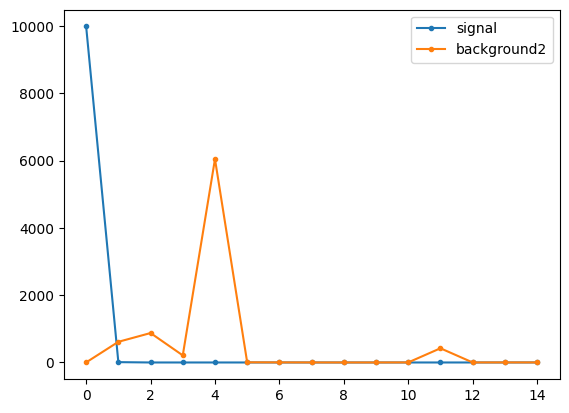

In [61]:
get_hist(best_individual)

In [ ]:
get_hist([torch.tensor([0,1,0])])

<Axes: >

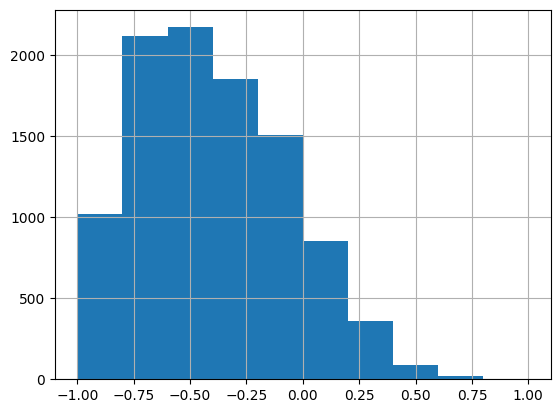

In [68]:
data_imp["n2n2"]["mmll"].hist()